In [99]:
import numpy as np

import numba

import matplotlib.pyplot as plt
%matplotlib inline

import auxiliary
import rotations

### Geometric properties

In [100]:
# length of the rod
length = 0.1

# diameter
radius = 0.0005

# cross-section area
A = np.pi * radius**2

# second moment of area
I = np.pi * radius**4 / 4

### Material properties

In [101]:
# E-modulus
E = 200e9

# shear modulus
G =  85e9

#?? names
GA = G * A
EA = E * A
EI = E * I
GJ = 2 * G * I

# elasticity tensor
C = np.diag([GA, GA, EA, EI, EI, GJ])

### Dicretization properties

In [102]:
# number of elements
n_el = 100

# number of nodes
n_n = n_el + 1

# length of each element
h_vector = np.ones((n_el)) * (length / n_el)

### Solution variables

Declaration in global namespace and initialization as a undeformed reference configuration

In [103]:
# centerline displacement at each node
centerline = np.zeros((3, n_n), dtype=float)
for i in range(n_el):
    centerline[2, i+1] = centerline[2, i] + h[i]

# rotation of crosssection at each node,
# axis-angle representation: 1 Euler vector per node
rotation = np.zeros((3, n_n), dtype=float)

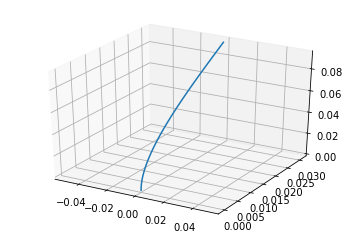

In [108]:
auxiliary.plot_centerline(centerline)

### Boundary conditions

The left end of the rod (i.e. s=0, node 0) is a Dirichlet boundary.

The right end of the rod (i.e. s=0.1, node `n_e = n_n-1`) is a Neumann boundary.

In [105]:
# force boundary condition at the right end (transverse load)
b1 = np.array([0, 1, 0, 0, 0, 0], dtype=float)

### Main program

In [86]:
def staticsolver():
    
    # counting iterations
    iteration = 0 
    
    # displacement increment vector
    increments = np.zeros((6*n_n), dtype=float)
    
    # norm of global incremental displacement vector
    # to keep track of convergence
    increments_norm = 0

    # must be stored persistently, so we can use Simo's update formula
    second_strain_invariant = np.zeros((3, n_el), dtype=float)
    
    
    # norm of residual vector
    # to keep track of convergence
    residuals_norm = 0
    
    
    # empty array for logging transverse load (at s=1, in direction 2)
    load_data = np.array([], dtype=float)
    
    # empty array for logging transverse displacement (at last node, in direction 2)
    displacement_data = np.array([], dtype=float)
    
    
    # we start simulation without load and increase the load gradually
    # -> load-controlled Newton-Rhapson
    desired_transverse_load = b1[1]
    b1[1] = 0
    
    print("begin Newton")
    
    # begin Newton-Rhapson iterations
    while(b1[1] < desired_transverse_load):
        iteration += 1
    
        # display output
        print('iteration', iteration)
        print('increments_norm', increments_norm)
        print('residuals_norm', residuals_norm)
        print('transverse load', b1[1])
    
        # when converged, change of boundary condition (load control)
        if(increments_norm < 1e-4 and residuals_norm < 1e-4):

            # logging
            #load_data = np.append(load_data, b1[1])
            #displacement_data = np.append(displacement_data, centerline[1, -1])
            #??col   = [b1[1], z0[1, -1], b1[1]*L**3/(3*EI)]
            
            # increasing transverse load
            b1[1] += 0.1
            print("added 0.1 now:", b1[1], "want", desired_transverse_load)
    
        #plot3(z0(3,:),z0(1,:),z0(2,:));
        #pause(.001);
        
        increments_norm, residuals_norm = jacobmat(increments, second_strain_invariant)

    #plot(data1(:,1),data1(:,2),'r');
    #plot(data1(:,1),data1(:,3),'b');
    #plt.plot(np.arange(len(load_data)), load_data)

### Solving the linearized problem

In [106]:
def jacobmat(increments, second_strain_invariant):
    
    # global residuals vector
    residuals = np.zeros((6*n_n), dtype=float)
    
    # global Jacobian matrix
    jac = np.zeros((6*n_n, 6*n_n), dtype=float)
    
    
    # iterating over all elements
    for i in range(1, n_n):
        
        # update configuration of element ...
        
        # update centerline at right node of element
        centerline[:, i] += increments[6*i:6*i+3]
        
        # update rotation at right node of element
        rotation[:, i] = rotations.update_euler(rotation[:, i], increments[6*i+3:6*i+6])
        
        
        
        # compute rotation matrix at midpoint of element ...
        
        # note that this interpolation is an approximation
        mid_euler = (rotation[:, i-1] + rotation[:, i]) / 2
        if np.linalg.norm(rotation[:, i] - rotation[:, i-1]) > np.pi:
            # required because extracted axial vector may differ by 2*pi
            print("a strange thing happened")
            # this is a hack!
            mid_euler = rotation[:, i-1]
        R = rotations.matrix_from_euler(mid_euler)
        
        
        
        # compute first invariant strain measure in the element ...
        
        # compute translational displacement tangent vector
        h = h_vector[i-1]
        centerline_tangent = (centerline[:, i] - centerline[:, i-1]) / h
        
        # first invariant strain measure
        first_strain_invariant = np.dot(R.T, centerline_tangent)
        # no axial strain <=> lambda_3 = 1
        first_strain_invariant[2] -= 1
        
        
        
        # compute second invariant strain measure in the element using Simo's formula ...
        
        # incremental rotation tangent vector
        incremental_euler_tangent = (increments[6*i+3:6*i+6] - increments[6*(i-1)+3:6*(i-1)+6]) / h
        
        # incremental Euler vector at midpoint of element
        mid_incremental_euler = (increments[6*i+3:6*i+6] + increments[6*(i-1)+3:6*(i-1)+6]) / 2
        norm_of_mid_incremental_euler = np.linalg.norm(mid_incremental_euler)
        
        # compute beta
        if norm_of_mid_incremental_euler < 1e-6:
            # use asymptotic approximation of Simo's formula to save computational cost
            beta = incremental_euler_tangent + \
                   0.5*np.cross(mid_incremental_euler, incremental_euler_tangent)
        else:
            x = np.sin(norm_of_mid_incremental_euler) / norm_of_mid_incremental_euler
            delu = mid_incremental_euler / norm_of_mid_incremental_euler
            beta = x*incremental_euler_tangent + \
                   (1-x) * np.dot(delu.T, incremental_euler_tangent) * delu + \
                   2 * (np.sin(0.5*norm_of_mid_incremental_euler) / norm_of_mid_incremental_euler)**2 * np.cross(mid_incremental_euler, incremental_euler_tangent)
        
        # updating the second strain invariant
        second_strain_invariant[:, i-1] += np.dot(R.T, beta)
        
        
        
        # compute internal reactions in inertial frame of the element ...
        
        forces = np.dot(R, np.array([C[0, 0]*first_strain_invariant[0],
                                     C[1, 1]*first_strain_invariant[1],
                                     C[2, 2]*first_strain_invariant[2]]))
        
        moments = np.dot(R, np.array([C[3, 3]*second_strain_invariant[0, i-1],
                                      C[4, 4]*second_strain_invariant[1, i-1],
                                      C[5, 5]*second_strain_invariant[2, i-1]]))
        
        
        
        # add contriubutions of the element to residual vector ...
        
        # contributions from internal forces and moments ??-crossphin
        crossphin = 0.5*h*np.cross(centerline_tangent, forces)
        residuals[6*(i-1):6*i] += np.hstack([-forces, -crossphin - moments])
        residuals[6*i:6*(i+1)] += np.hstack([+forces, -crossphin + moments])

        
        
        # add contributions of the element to Jacobian matrix ...              
        
        # ?? symmetrize?
        C11 = np.dot(np.dot(R, C[0:3, 0:3]), R.T)
        C11 = (C11 + C11.T) / 2
        C12 = np.dot(np.dot(R, C[0:3, 3:6]), R.T)
        C21 = C12.T
        C22 = np.dot(np.dot(R, C[3:6, 3:6]), R.T)
        C22 = (C22 + C22.T) / 2

        centerline_tangent_cross = auxiliary.skew_matrix_from_vector(centerline_tangent)
        forces_cross = auxiliary.skew_matrix_from_vector(forces)
        moments_cross = auxiliary.skew_matrix_from_vector(moments)

        # material tangent stiffness (symmetric part)
        jac[6*(i-1):6*i, 6*(i-1):6*i] += np.block([[C11 / h,
                                                    -0.5*np.dot(C11, centerline_tangent_cross) + C12 / h],
                                                   [-0.5*np.dot(centerline_tangent_cross.T, C11) + C21 / h,
                                                    np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 3) - 0.5*np.dot(centerline_tangent_cross.T, C12) + np.dot(C21, centerline_tangent_cross) + C22 / h]])
        
        jac[6*i:6*(i+1), 6*i:6*(i+1)] += np.block([[C11 / h,
                                                    0.5*np.dot(C11, centerline_tangent_cross) + C12 / h],
                                                   [0.5*np.dot(centerline_tangent_cross.T, C11) + C21 / h,
                                                    np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 3) + 0.5*np.dot(centerline_tangent_cross.T, C12) + np.dot(C21, centerline_tangent_cross) + C22 / h]])
        
        jac[6*i:6*(i+1), 6*(i-1):6*i] += np.block([[-C11 / h,
                                                    0.5*np.dot(C11, centerline_tangent_cross) - C12 / h],
                                                   [-0.5*np.dot(centerline_tangent_cross.T, C11) - C21 / h,
                                                    np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 6) - 0.5*np.dot(centerline_tangent_cross.T, C12) - np.dot(C21, centerline_tangent_cross) - C22 / h]])
        
        jac[6*(i-1):6*i, 6*i:6*(i+1)] += np.block([[-C11 / h,
                                                    -0.5*np.dot(C11, centerline_tangent_cross) - C12 / h],
                                                   [0.5*np.dot(centerline_tangent_cross.T, C11) - C21 / h,
                                                    np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 6) + 0.5*np.dot(centerline_tangent_cross.T, C12) - np.dot(C21, centerline_tangent_cross) - C22 / h]])
        
        # geometric tangent stiffness (non-symmetric)
        jac[6*(i-1):6*i, 6*(i-1):6*i] += np.block([[np.zeros((3,3)), 0.5*forces_cross],
                                                   [-0.5*forces_cross, 0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 3)]])
        
        jac[6*i:6*(i+1), 6*i:6*(i+1)] += np.block([[np.zeros((3,3)), -0.5*forces_cross],
                                                   [0.5*forces_cross, -0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 3)]])
        
        jac[6*i:6*(i+1), 6*(i-1):6*i] += np.block([[np.zeros((3,3)), -0.5*forces_cross],
                                                   [-0.5*forces_cross, -0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 6)]])
        
        jac[6*(i-1):6*i, 6*i:6*(i+1)] += np.block([[np.zeros((3,3)), 0.5*forces_cross],
                                                   [0.5*forces_cross, 0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 6)]])
        
        # tangent due to distributive load
        
        # tangent due to boundary loads
        
    
    # apply Neumann boundary conditions
    #residuals[0:6] += b0 # is a Dirichlet boundary
    residuals[-6:] -= b1
                                                                                                                         
    # solve the linearized problem
    increments[6:] = np.linalg.solve(-jac[6:, 6:], residuals[6:])
                                                                                                             
    increments_norm = np.linalg.norm(increments[6:])
    
    # ??                                                                                                                     
    if increments_norm > 1:
        increments[6:] = increments[6:] / increments_norm
    
    residuals_norm = np.linalg.norm(residuals[6:])

    return increments_norm, residuals_norm

In [107]:
b1[1] = 1
staticsolver()

begin Newton
iteration 1
increments_norm 0
residuals_norm 0
transverse load 0.0
added 0.1 now: 0.1 want 1.0
iteration 2
increments_norm 0.238753828723
residuals_norm 0.1
transverse load 0.1
iteration 3
increments_norm 0.00644655598908
residuals_norm 83.4817471258
transverse load 0.1
iteration 4
increments_norm 0.0819502930398
residuals_norm 0.0314373506704
transverse load 0.1
iteration 5
increments_norm 0.0102212270058
residuals_norm 10.182038154
transverse load 0.1
iteration 6
increments_norm 0.0230488199998
residuals_norm 0.131672025957
transverse load 0.1
iteration 7
increments_norm 0.00774454990053
residuals_norm 0.841229831346
transverse load 0.1
iteration 8
increments_norm 0.00399346485064
residuals_norm 0.0942609765791
transverse load 0.1
iteration 9
increments_norm 0.00150924276868
residuals_norm 0.0255818493655
transverse load 0.1
iteration 10
increments_norm 0.00055235260343
residuals_norm 0.00366141792694
transverse load 0.1
iteration 11
increments_norm 0.000199926347112
res

iteration 85
increments_norm 2.69419390858e-09
residuals_norm 6.88270547962e-05
transverse load 0.4
added 0.1 now: 0.5 want 1.0
iteration 86
increments_norm 0.231205845459
residuals_norm 0.0999749748716
transverse load 0.5
iteration 87
increments_norm 0.00651250943421
residuals_norm 78.0391772994
transverse load 0.5
iteration 88
increments_norm 0.075777898491
residuals_norm 0.03062420021
transverse load 0.5
iteration 89
increments_norm 0.0103391432816
residuals_norm 8.66907557578
transverse load 0.5
iteration 90
increments_norm 0.0199435958272
residuals_norm 0.136420631266
transverse load 0.5
iteration 91
increments_norm 0.0067974138511
residuals_norm 0.627291875051
transverse load 0.5
iteration 92
increments_norm 0.00315760560555
residuals_norm 0.0724620353175
transverse load 0.5
iteration 93
increments_norm 0.00115091075918
residuals_norm 0.015897702669
transverse load 0.5
iteration 94
increments_norm 0.000408105933777
residuals_norm 0.0021150805953
transverse load 0.5
iteration 95
i

iteration 169
increments_norm 2.44477938609e-09
residuals_norm 5.76282471715e-05
transverse load 0.8
added 0.1 now: 0.9 want 1.0
iteration 170
increments_norm 0.211894429626
residuals_norm 0.0999785821832
transverse load 0.9
iteration 171
increments_norm 0.0068280652004
residuals_norm 64.9593377808
transverse load 0.9
iteration 172
increments_norm 0.0640181544309
residuals_norm 0.0306609023329
transverse load 0.9
iteration 173
increments_norm 0.0103685805384
residuals_norm 6.13212413906
transverse load 0.9
iteration 174
increments_norm 0.0145038809672
residuals_norm 0.140322038701
transverse load 0.9
iteration 175
increments_norm 0.00494857442087
residuals_norm 0.328290752476
transverse load 0.9
iteration 176
increments_norm 0.00192812668657
residuals_norm 0.0380841249703
transverse load 0.9
iteration 177
increments_norm 0.000654645968878
residuals_norm 0.00583290969157
transverse load 0.9
iteration 178
increments_norm 0.000218648455413
residuals_norm 0.000671607971248
transverse load 